# Clustering of disease node embedding vectors

In previous steps of the workflow we:
 * Constructed an ontology enriched rare disease focused knowledge graph
 * Performed random walks originating at each rare disease node
 * Used those random walks as corpuses for fitting word2vec vector embedding models

The next step is to use the embedding vectors for the disease nodes as features in unuspervised clustering models. The purpose of this notebook is to illustrate our approach to clustering and do some light visual analysis of the results.

In [ ]:
import sys
import os
import pickle
from collections import Counter
import glob
import gensim
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn import cluster,metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, Normalizer
import umap
from gensim.models import Word2Vec
from joblib import Parallel, delayed

## Load the knowledge graph

In [ ]:
with open('/data/binderjl/RD-Clust/data/processed/disease_ontograph.pkl', 'rb') as f:
    disease_ontograph = pickle.load(f)

#Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

#Extract diseases
diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

## Load the real embedding model

In [ ]:
model = gensim.models.Word2Vec.load(f'/data/binderjl/RD-Clust/data/embeddings/ontograph_embed_N250_L250_D32_K20.model')

#obtain the disease vectors
disease_vectors = model.wv[diseases]

#Standardize because we pulled the disease vectors out from full embedding model
standard_vectors = StandardScaler().fit_transform(disease_vectors)

#Normalize because magnitude of embedding vector corresponds to frequency. We care about context, which is reflected in the direction of the vector
normalized_vectors = Normalizer().fit_transform(standard_vectors)
m_file = "/data/binderjl/RD-Clust/data/clusters/kmeans/ontograph_embed_N250_L250_D32_K20_KMEANS_KOPT37.pkl"
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)

realdata = {}
realdata['K_clust'] = len(set(cluster_model.labels_))
realdata['silhouette_euclidean'] = metrics.silhouette_score(normalized_vectors, cluster_model.labels_, metric='euclidean')
realdata['davies_bouldin'] = metrics.davies_bouldin_score(normalized_vectors, cluster_model.labels_)
realdata['calinski_harabasz'] = metrics.calinski_harabasz_score(normalized_vectors, cluster_model.labels_)


/usr/local/Anaconda/envs/py3.8/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.0.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
realdata

{'K_clust': 37,
 'silhouette_euclidean': 0.082066946,
 'davies_bouldin': 2.452422352092014,
 'calinski_harabasz': 79.38576288962868}

In [ ]:
normalized_vectors.shape

(3242, 32)

### Visualization REAL model with t-SNE

t-SNE is a manifold learning based dimensionality reduction method. I will use it to project my embedding vectors down into a 2 dimensional space and overlay the cluster assignment labels to see the clustering. This is a loose non-quantitative visual inspection of the cluster quality

In [ ]:
cluster_labels= cluster_model.labels_
cluster_count = Counter(cluster_model.labels_)
cluster_dist = Counter(sorted(cluster_count.values(),reverse=True))
clust, cnt = zip(*cluster_dist.items())
transform = TSNE
trans = transform(n_components=2,early_exaggeration=10)
node_embeddings_2d = trans.fit_transform(normalized_vectors)

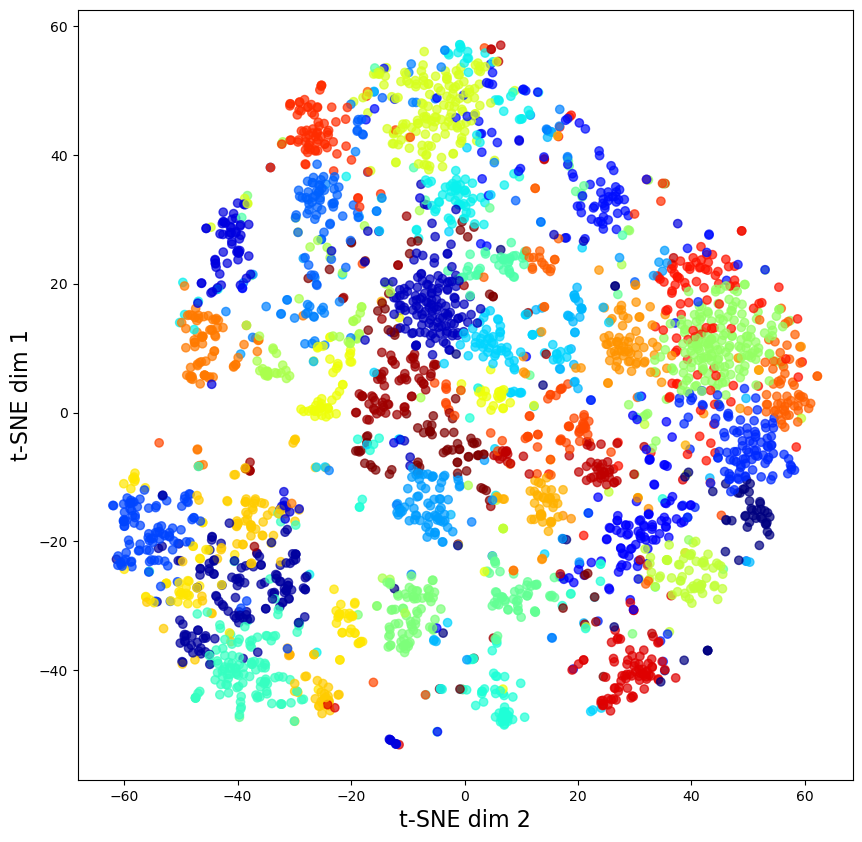

In [ ]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
#node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10,10), facecolor='white', edgecolor='k')
#plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=cluster_labels,
    cmap="jet",
    alpha=alpha,
)
#plt.grid(b=None)
plt.xlabel("t-SNE dim 2",size=16)
plt.ylabel("t-SNE dim 1",size=16)
#plt.title("t-SNE visualization of disease embeddings".format(transform.__name__),size=20)
plt.show()

## Loop through random models

In [ ]:
random_clust_summary =[]

for i in range(1,101):
    model = gensim.models.Word2Vec.load(f'/data/binderjl/RD-Clust/data/embeddings/random_ontograph_embed_{i}.model')

    #obtain the disease vectors
    disease_vectors = model.wv[diseases]

    #Standardize because we pulled the disease vectors out from full embedding model
    standard_vectors = StandardScaler().fit_transform(disease_vectors)

    #Normalize because magnitude of embedding vector corresponds to frequency. We care about context, which is reflected in the direction of the vector
    normalized_vectors = Normalizer().fit_transform(standard_vectors)
    m_file = glob.glob(f"/data/binderjl/RD-Clust/data/clusters/kmeans/random_ontograph_embed_{i}_KMEANS_KOPT*.pkl")
    if len(m_file)>0:
        with open(m_file[0], 'rb') as f:
            cluster_model = pickle.load(f)
    else:
        continue

    mdata = {}
    mdata['K_clust'] = len(set(cluster_model.labels_))
    mdata['silhouette_euclidean'] = metrics.silhouette_score(normalized_vectors, cluster_model.labels_, metric='euclidean')
    mdata['davies_bouldin'] = metrics.davies_bouldin_score(normalized_vectors, cluster_model.labels_)
    mdata['calinski_harabasz'] = metrics.calinski_harabasz_score(normalized_vectors, cluster_model.labels_)
    random_clust_summary.append(mdata)


/usr/local/Anaconda/envs/py3.8/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Anaconda/envs/py3.8/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Anaconda/envs/py3.8/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.3.0. Thi

In [ ]:
mdata

{'K_clust': 44,
 'silhouette_euclidean': 0.027229633,
 'davies_bouldin': 3.196170818206029,
 'calinski_harabasz': 19.50932570681212}

In [ ]:
normalized_vectors.shape

(3242, 32)

In [ ]:
cluster_metrics_df = pd.DataFrame(random_clust_summary)
cluster_metrics_df
cluster_metrics_df.to_csv("random_cluster_metrics.csv", index=False)

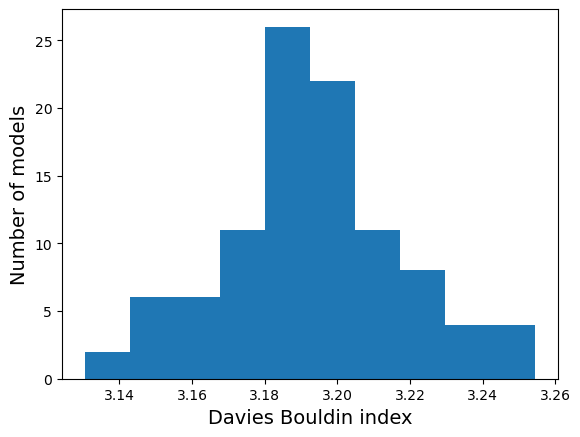

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.hist(cluster_metrics_df.davies_bouldin)
plt.ylabel('Number of models',size=14)
plt.xlabel('Davies Bouldin index',size=14)
plt.show()

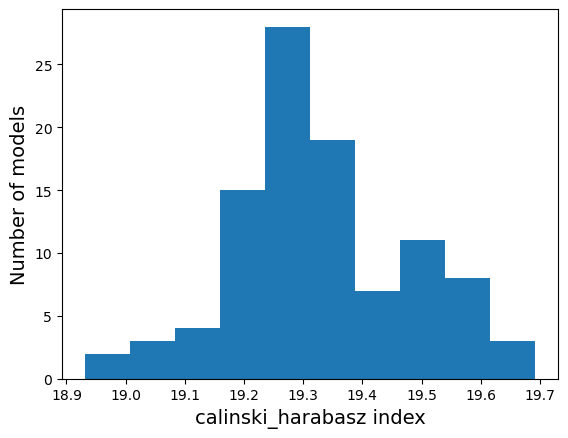

In [ ]:
plt.hist(cluster_metrics_df.calinski_harabasz)
plt.ylabel('Number of models',size=14)
plt.xlabel('calinski_harabasz index',size=14)
plt.show()

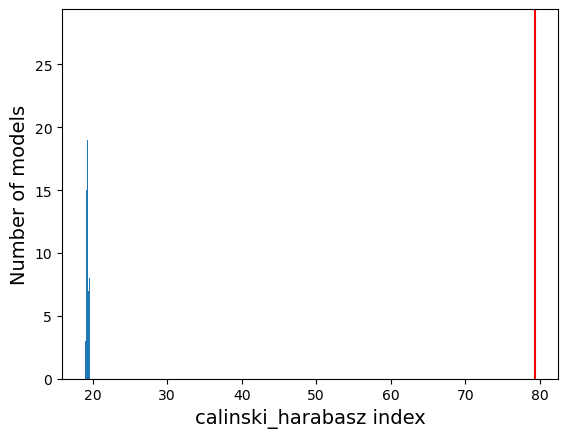

In [ ]:
plt.hist(cluster_metrics_df.calinski_harabasz)
plt.axvline(x=realdata["calinski_harabasz"],color="r")
plt.ylabel('Number of models',size=14)
plt.xlabel('calinski_harabasz index',size=14)
plt.show()

### Visualization of random models with t-SNE

t-SNE is a manifold learning based dimensionality reduction method. I will use it to project my embedding vectors down into a 2 dimensional space and overlay the cluster assignment labels to see the clustering. This is a loose non-quantitative visual inspection of the cluster quality

In [ ]:
transform = TSNE
trans = transform(n_components=2,early_exaggeration=10)
node_embeddings_2d = trans.fit_transform(normalized_vectors)

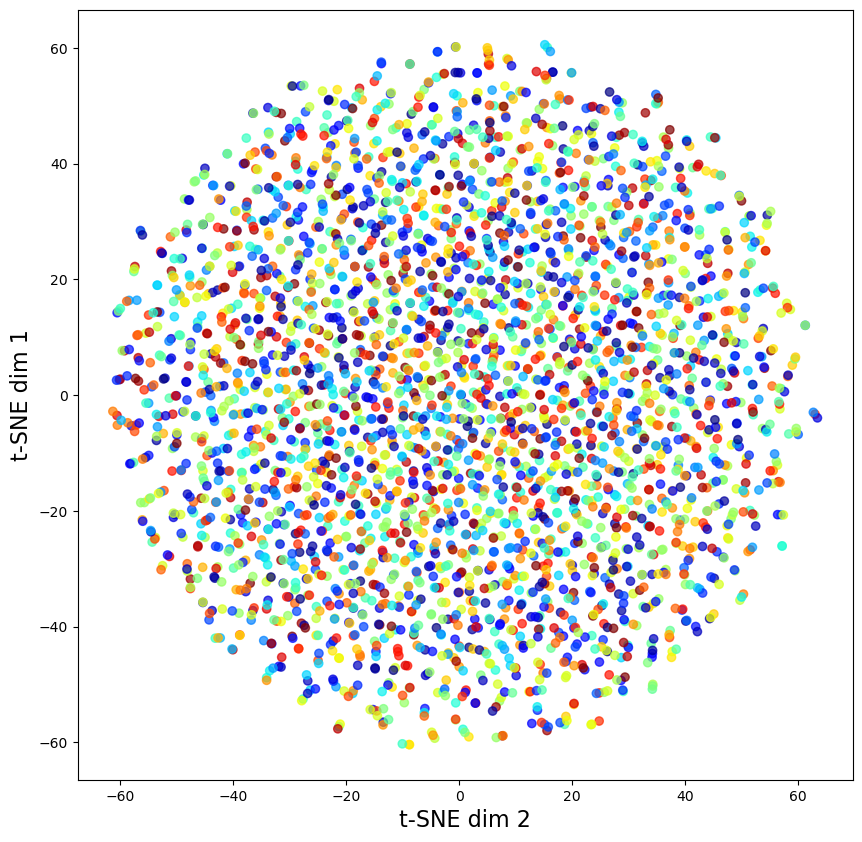

In [ ]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
#node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10,10), facecolor='white', edgecolor='k')
#plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=cluster_labels,
    cmap="jet",
    alpha=alpha,
)
#plt.grid(b=None)
plt.xlabel("t-SNE dim 2",size=16)
plt.ylabel("t-SNE dim 1",size=16)
#plt.title("t-SNE visualization of disease embeddings".format(transform.__name__),size=20)
plt.show()